In [1]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
from fastai.callbacks import *
import PIL
import cv2
import sklearn
import skimage
bs = 32

In [2]:
path_images = Path('/home/samudre/Music/1May/stage2')

In [3]:
data = ImageDataBunch.from_folder(path=path_images, train='train', valid='valid', bs=bs, classes=['TT', 'others'])
data.normalize()

ImageDataBunch;

Train: LabelList (956 items)
x: ImageList
Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620)
y: CategoryList
others,others,others,others,others
Path: /home/samudre/Music/1May/stage2;

Valid: LabelList (252 items)
x: ImageList
Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620)
y: CategoryList
others,others,others,others,others
Path: /home/samudre/Music/1May/stage2;

Test: None

In [4]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-04
Min loss divided by 10: 6.92E-03


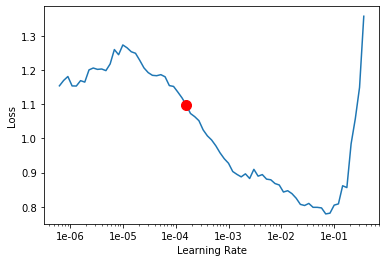

In [5]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [6]:
learn.fit_one_cycle(1, max_lr=slice(3e-4, 7e-2) )

epoch,train_loss,valid_loss,error_rate,time
0,1.421010,2.330374,0.242063,00:06


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 2.75E-05


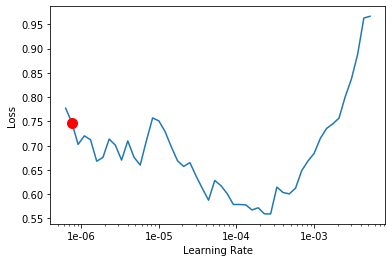

In [8]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [9]:
learn.fit_one_cycle(2, max_lr=slice(3e-5, 2e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.820494,1.351952,0.186508,00:07
1,0.592245,0.725318,0.123016,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.287956,0.868980,0.130952,00:07
1,0.367468,0.817580,0.130952,00:07
2,0.485355,0.742066,0.150794,00:07
3,0.420513,0.219716,0.055556,00:07
4,0.320562,0.098397,0.027778,00:07
5,0.251152,0.360954,0.063492,00:07
6,0.242640,0.235985,0.039683,00:07
7,0.182631,0.144045,0.031746,00:07
8,0.120823,0.139628,0.035714,00:07
9,0.079810,0.142504,0.031746,00:07


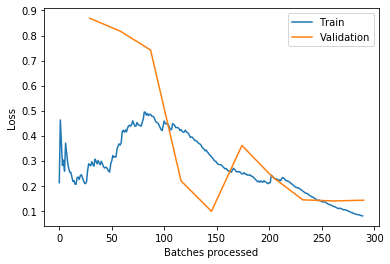

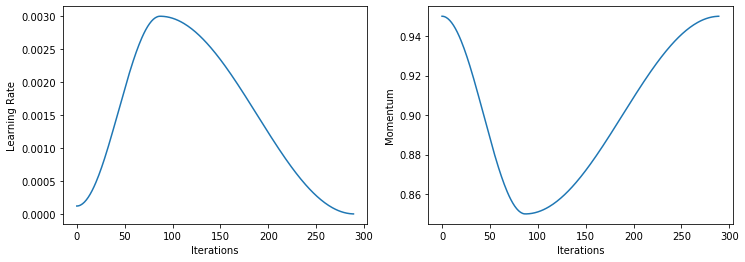

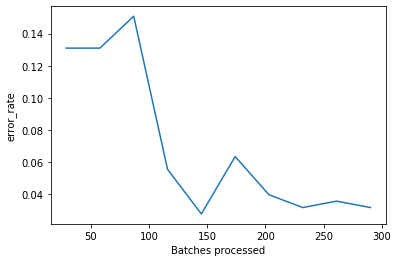

In [10]:
learn.fit_one_cycle(10)
learn.recorder.plot_losses()
# # schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_metrics()

In [11]:
learn.save('1may-tvso-r50')

In [12]:
learn.export('1may-tvso-r50.pkl')

In [13]:
learn.load('1may-tvso-r50')

Learner(data=ImageDataBunch;

Train: LabelList (956 items)
x: ImageList
Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620)
y: CategoryList
others,others,others,others,others
Path: /home/samudre/Music/1May/stage2;

Valid: LabelList (252 items)
x: ImageList
Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620)
y: CategoryList
others,others,others,others,others
Path: /home/samudre/Music/1May/stage2;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1,

In [14]:
interpret = ClassificationInterpretation.from_learner(learn)

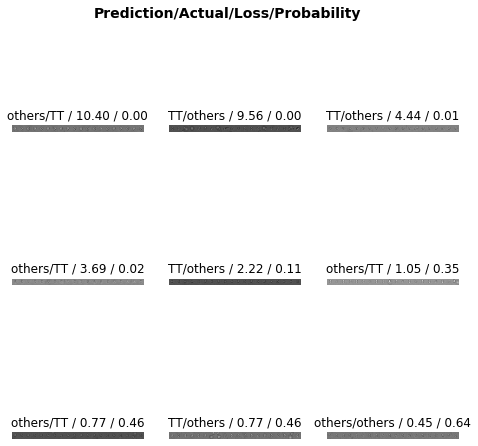

In [15]:
interpret.plot_top_losses(9, figsize=(8,8))

In [16]:
losses, indexes = interpret.top_losses(50)

top_loss_paths = data.valid_ds.x.items[indexes]

print(top_loss_paths)

[PosixPath('/home/samudre/Music/1May/stage2/valid/TT/BK1010_10s02_68.jpg')
 PosixPath('/home/samudre/Music/1May/stage2/valid/others/BK1024_10s02_216.jpg')
 PosixPath('/home/samudre/Music/1May/stage2/valid/others/BK1017_10s03_176.jpg')
 PosixPath('/home/samudre/Music/1May/stage2/valid/TT/BK0926_10s02_56.jpg')
 PosixPath('/home/samudre/Music/1May/stage2/valid/others/BK1024_10s01_235.jpg')
 PosixPath('/home/samudre/Music/1May/stage2/valid/TT/BK1010_10s01_9.jpg')
 PosixPath('/home/samudre/Music/1May/stage2/valid/TT/BK1024_10s01_215.jpg')
 PosixPath('/home/samudre/Music/1May/stage2/valid/others/BK1010_10s02_233.jpg')
 PosixPath('/home/samudre/Music/1May/stage2/valid/others/BK1003_10s03_152.jpg')
 PosixPath('/home/samudre/Music/1May/stage2/valid/TT/BM1024_10s02_87.jpg')
 PosixPath('/home/samudre/Music/1May/stage2/valid/TT/BK1017_10s01_50.jpg')
 PosixPath('/home/samudre/Music/1May/stage2/valid/others/BK1003_10s01_183.jpg')
 PosixPath('/home/samudre/Music/1May/stage2/valid/others/BG1008_10s02_

In [ ]:
###################  INTERNAL VALIDATION RESULTS  ##################

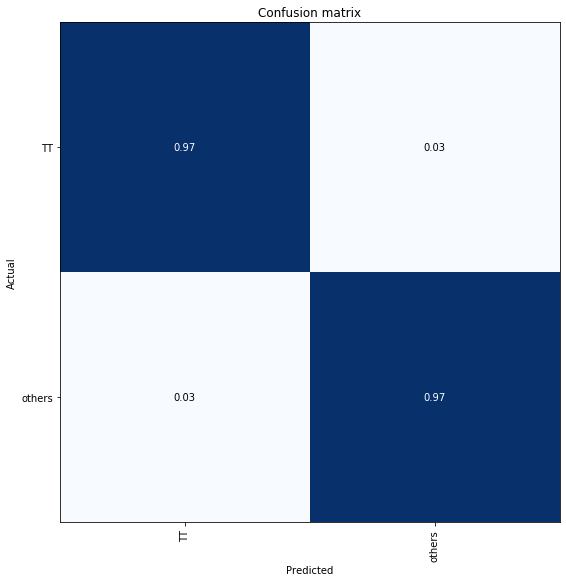

In [17]:
interpret.plot_confusion_matrix(normalize=True, figsize=(8,8))

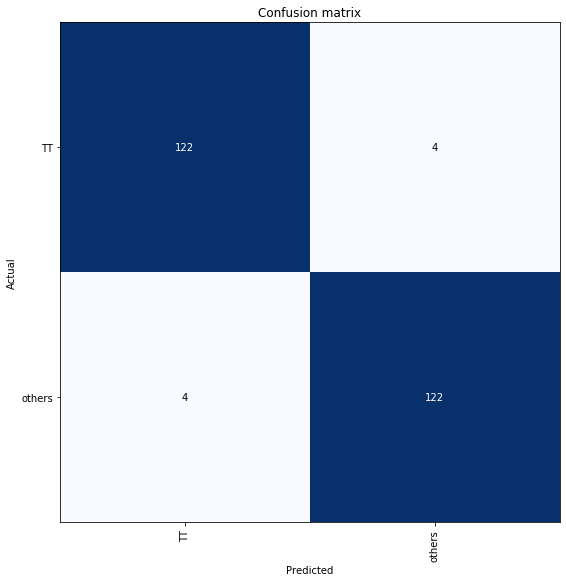

In [18]:
interpret.plot_confusion_matrix(figsize=(8,8))

In [ ]:
#################  VALIDATION (3 BK + 1 BG) ############### 

In [20]:
import glob
g1 = glob.glob('/home/samudre/Music/1May/validation/data-stage2/others/*')
g2 = glob.glob('/home/samudre/Music/1May/validation/data-stage2/TT/*')

TP_others = 0
OasT = 0
TP_T = 0
TasO = 0

validation_model = load_learner('/home/samudre/Music/1May/stage2/model', test=ImageList.from_folder('/home/samudre/Music/1May/validation'))
for each in g1:
    p,q,r = validation_model.predict(open_image(each))
    if str(p) == 'others':
        TP_others += 1
    else:
        OasT += 1
        
for each in g2:
    p,q,r = validation_model.predict(open_image(each))
    if str(p) == 'TT':
        TP_T += 1
    else:
        TasO += 1

print('TP_others: ' + str(TP_others))
print('Others-TT: ' + str(OasT))
print('TP_TT: ' + str(TP_T))
print('TT-others: ' + str(TasO))

TP_others: 80
Others-TT: 1
TP_TT: 91
TT-others: 4
